In [24]:
# Import necessary libraries
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Import specific components from TensorFlow and Keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Model
from tensorflow.keras import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Resizing, Normalization, Conv1D

In [25]:
# Define the file path for the data
url = 'North.txt'

# Read the data from the specified CSV file into a pandas DataFrame
df = pd.read_csv(url)

# Drop the '4606' column from the DataFrame
df = df.drop(columns=['4606'])

# Display the first few rows of the DataFrame
print(df.head())

# Group the DataFrame by the 'SAMPLE' column
grouped = df.groupby('SAMPLE')

# Extract data groups for each 'SAMPLE' into a list
data = [group for name, group in grouped]

# Initialize lists to store targets and features
targets = []
features = []

# Iterate over each group of data
for sample_df in data:
    # Extract the 'WIND_SPEED' values and calculate the mean
    target = sample_df['WIND_SPEED'].values
    targets.append(np.mean(target))

    # Extract 'MIC_A' and 'MIC_B' values for each 'SAMPLE'
    pair = []
    feature_columns = ['MIC_A', 'MIC_B']
    for column in feature_columns:
        pair.append(sample_df[f'{column}'].values)
    features.append(pair)


   SAMPLE  WIND_SPEED  MIC_A  MIC_B
0       1         0.0      0      0
1       1         0.0      0      0
2       1         0.0      0      0
3       1         0.0      0      0
4       1         0.0      0      0


In [35]:
# Initialize new lists to filter features and targets based on length conditions
newFeatures = []
newTargets = []

# Iterate through each set of features
for i in range(len(features)):
    # Check if the lengths of both 'MIC_A' and 'MIC_B' are 768
    if (len(features[i][0]) == 768 and len(features[i][1]) == 768):
        # If the condition is met, add the features and targets to the new lists
        newFeatures.append(features[i])
        newTargets.append(targets[i])

# Update the original features and targets lists with the filtered data
features = newFeatures
targets = newTargets

# Perform min-max normalization on each nested array
min_values = np.min(features, axis=2, keepdims=True)
max_values = np.max(features, axis=2, keepdims=True)

# Normalize the features using min-max normalization
features = (features - min_values) / (max_values - min_values)

# Print the maximum value in the targets array
print(np.max(targets))


12.25


In [37]:
# Initialize lists to store spectrograms for each feature column
spectrogramsA = []
spectrogramsB = []

# Function to compute spectrogram from audio data
def compute_spectrogram(audio_data, sample_rate=512, max_frequency=51):
    # Convert audio data to a TensorFlow constant with float32 data type
    audio_data = tf.constant(audio_data, dtype=tf.float32)

    # Compute short-time Fourier transform (STFT) of the audio data
    spectrogram = tf.signal.stft(audio_data, frame_length=255, frame_step=129)

    # Calculate the magnitude of the spectrogram
    spectrogram = tf.abs(spectrogram)

    # Apply logarithmic scaling to the spectrogram to enhance features
    spectrogram = tf.math.log(spectrogram + 1e-9)

    # Add an additional axis to the spectrogram to give it tensor-like shape
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

# Iterate through each set of features
for feature in features:
    # Define the indices of the feature columns
    feature_columns = [0, 1]

    # Iterate through each feature column
    for column in feature_columns:
        # Extract audio data from the feature column
        audio_data = feature[column]

        # Compute the spectrogram for the audio data
        spec = compute_spectrogram(audio_data)

        # Append the computed spectrogram to the appropriate list based on the column index
        if column == 0:
            spectrogramsA.append(spec)
        else:
            spectrogramsB.append(spec)


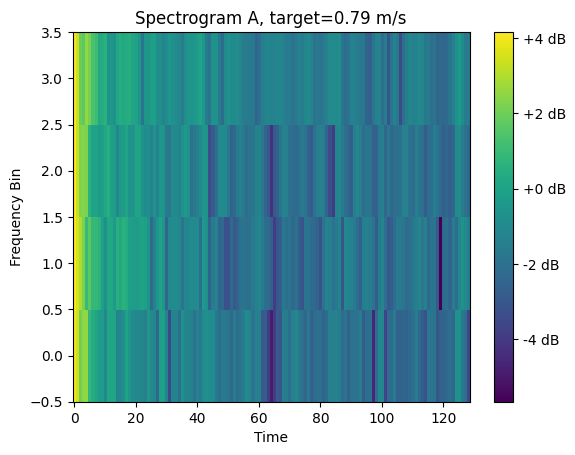

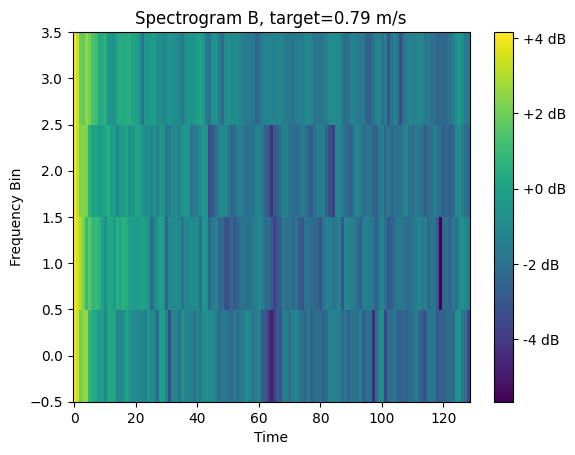

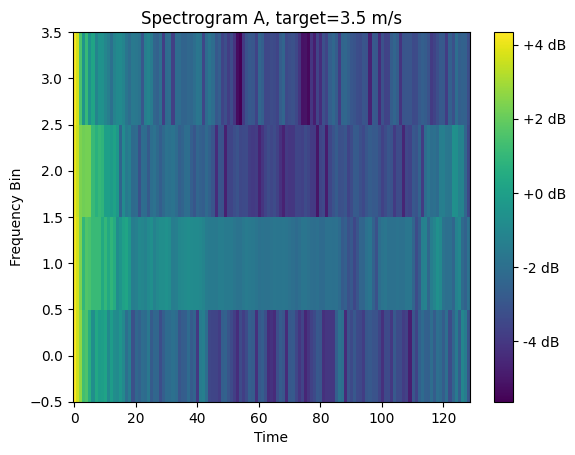

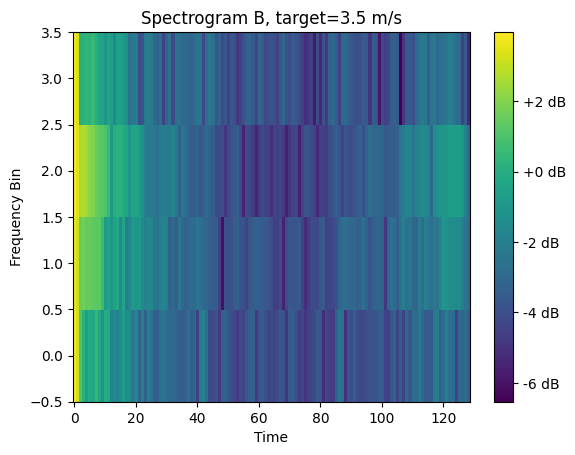

In [38]:
# Display spectrogram for sample 20 in 'spectrogramsA'
spec = np.squeeze(spectrogramsA[20].numpy())
plt.imshow(spec, aspect='auto', origin='lower')
plt.title(f'Spectrogram A, target={targets[20]} m/s')  # Set the title with the corresponding target value
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Display spectrogram for sample 20 in 'spectrogramsB'
spec = np.squeeze(spectrogramsB[20].numpy())
plt.imshow(spec, aspect='auto', origin='lower')
plt.title(f'Spectrogram B, target={targets[20]} m/s')  # Set the title with the corresponding target value
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Display spectrogram for sample 750 in 'spectrogramsA'
spec = np.squeeze(spectrogramsA[750].numpy())
plt.imshow(spec, aspect='auto', origin='lower')
plt.title(f'Spectrogram A, target={targets[750]} m/s')  # Set the title with the corresponding target value
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Display spectrogram for sample 750 in 'spectrogramsB'
spec = np.squeeze(spectrogramsB[750].numpy())
plt.imshow(spec, aspect='auto', origin='lower')
plt.title(f'Spectrogram B, target={targets[750]} m/s')  # Set the title with the corresponding target value
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.show()


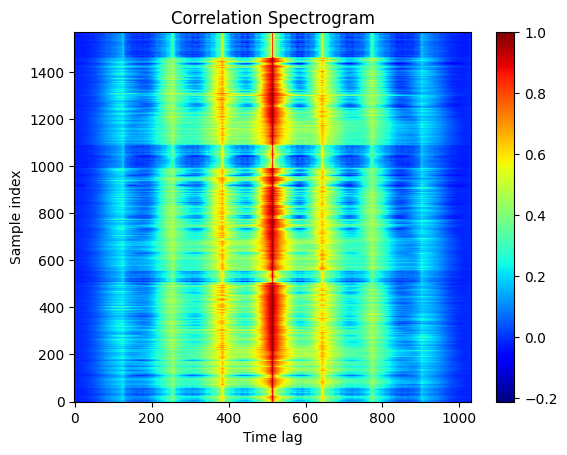

In [39]:
# Initialize a list to store correlation spectrograms
correlation_spectrogram = []

# Iterate through pairs of spectrograms from 'spectrogramsA' and 'spectrogramsB'
for specA, specB in zip(spectrogramsA, spectrogramsB):
    # Ensure that both spectrograms have the same shape for correlation
    assert specA.shape == specB.shape, "Spectrograms must have the same shape for correlation"

    # Flatten and compute cross-correlation between the two spectrograms
    cross_corr = np.correlate(np.array(specA).flatten(), np.array(specB).flatten(), mode='full')

    # Normalize the cross-correlation values
    normalized_cross_corr = cross_corr / np.max(np.abs(cross_corr))

    # Append the normalized cross-correlation to the list
    correlation_spectrogram.append(normalized_cross_corr)

# Convert the list of correlation spectrograms to a numpy array
correlation_spectrogram = np.array(correlation_spectrogram)

# Display the correlation spectrogram
plt.imshow(correlation_spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title('Correlation Spectrogram')
plt.xlabel('Time lag')
plt.ylabel('Sample index')
plt.colorbar()
plt.show()

In [60]:
# Concatenate spectrograms from 'spectrogramsA' and 'spectrogramsB' along the last axis
spectrogram_pair_train = tf.concat([spectrogramsA, spectrogramsB], axis=-1)

# Split the data into training and testing sets
X_train = spectrogram_pair_train[:1200]
X_test = spectrogram_pair_train[1200:]
y_train = np.array(targets[:1200])
y_test = np.array(targets[1200:])

# Display the shapes of the training data and labels
print(X_train.shape)
print(y_train.shape)

# Create a TensorFlow dataset for the training set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle the dataset, create batches, and prefetch for optimization
train_dataset = train_dataset.shuffle(buffer_size=len(spectrogram_pair_train)).batch(batch_size=256).prefetch(tf.data.experimental.AUTOTUNE)

# Create a TensorFlow dataset for the testing set
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Create batches and prefetch for optimization
test_dataset = test_dataset.batch(batch_size=256).prefetch(tf.data.experimental.AUTOTUNE)


(1200, 4, 129, 2)
(1200,)


In [61]:
# Defining the model
model = Sequential()
model.add(Resizing(32,32))
model.add(Normalization())

model.add(Conv2D(32, (2, 2), padding='same', activation = 'relu', input_shape = X_train.shape))

model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) # Adding dropouts to avoid overfitting

model.add(Flatten())

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(1))

model.build(input_shape=X_train.shape)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (1200, 32, 32, 2)         0         
                                                                 
 normalization_4 (Normaliza  (1200, 32, 32, 2)         5         
 tion)                                                           
                                                                 
 conv2d_26 (Conv2D)          (1200, 32, 32, 32)        288       
                                                                 
 conv2d_27 (Conv2D)          (1200, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_15 (MaxPooli  (1200, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (1200, 16, 16, 64)      

In [67]:
epochs = 100 #Compiling model
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae'])

In [68]:
history = model.fit(train_dataset, epochs = epochs, validation_data = test_dataset, verbose=1) # Learning a model

Epoch 1/100
5/5 [==============================] - 2s 59ms/step - loss: 2.2012 - mae: 1.1305 - val_loss: 2.5228 - val_mae: 1.0630
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 1.8283 - mae: 0.9996 - val_loss: 2.2404 - val_mae: 1.0252
Epoch 3/100
5/5 [==============================] - 0s 28ms/step - loss: 1.5840 - mae: 0.9220 - val_loss: 2.1786 - val_mae: 1.0354
Epoch 4/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5329 - mae: 0.9000 - val_loss: 2.1749 - val_mae: 1.0248
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 1.5881 - mae: 0.9061 - val_loss: 2.1781 - val_mae: 1.0361
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4963 - mae: 0.8907 - val_loss: 2.2350 - val_mae: 1.0363
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 1.5624 - mae: 0.9145 - val_loss: 2.1509 - val_mae: 1.0424
Epoch 8/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4178 - mae: 0.87

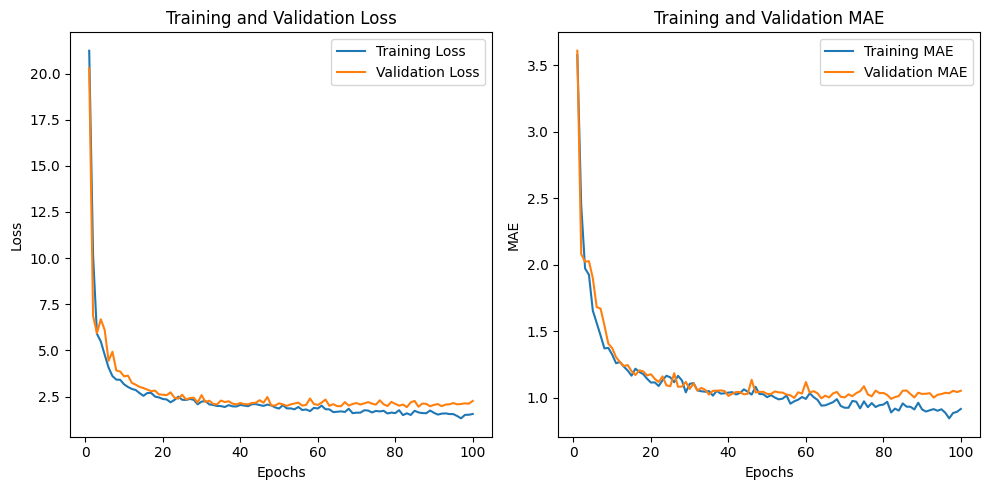

In [64]:
train_loss = history.history['loss']
train_mae = history.history['mae']

val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_mae, label='Training MAE')
plt.plot(range(1, epochs + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()